<a href="https://colab.research.google.com/github/silverstar0727/ML-Pipeline-Tutorial/blob/main/sklearn_pipeline(viz).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 설치 및 라이브러리 임포트

In [3]:
# 해당 셀을 실행한 후에 반드시 "런타임 다시시작"을 해주세요
!pip install -q kfp
!pip3 install --user kfp google-cloud-aiplatform matplotlib --upgrade -q

In [25]:
from typing import NamedTuple
import json 

import kfp
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, ClassificationMetrics, Metrics)
from kfp.v2.google.client import AIPlatformClient
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## GCP 연결

In [26]:
# gcp 연결
from google.colab import auth as google_auth

google_auth.authenticate_user()

# 경로변수 설정
아래 항목들을 본인 환경에 맞게 수정해주세요.

* PROJECT_ID = <프로젝트 ID>
* REGION = <리전>
* BUCKET_NAME = <bucket 이름>
* USER = <user 이름>

In [27]:
from datetime import datetime

PROJECT_ID = 'mlops-210515'
REGION = "us-central1"

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME = "gs://pipeline-129332"

USER = "JeongMin-Do"
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

#aiplatform.init(project=PROJECT_ID)

# Scikit-Learn

#### Wine classification

In [28]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
    output_component_file="wine_classif_component.yaml",
)
def wine_classification(wmetrics: Output[ClassificationMetrics]):
    from sklearn.datasets import load_wine
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import cross_val_predict, train_test_split

    X, y = load_wine(return_X_y=True)
    # Binary classification problem for label 1.
    y = y == 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    y_scores = cross_val_predict(rfc, X_train, y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(
        y_true=y_train, y_score=y_scores[:, 1], pos_label=True
    )
    wmetrics.log_roc_curve(fpr, tpr, thresholds)

#### Iris sgd classifier

In [29]:
@component(packages_to_install=["sklearn"], base_image="python:3.9")
def iris_sgdclassifier(
    test_samples_fraction: float,
    metricsc: Output[ClassificationMetrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import confusion_matrix

    iris_dataset = datasets.load_iris()
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        iris_dataset["data"],
        iris_dataset["target"],
        test_size=test_samples_fraction,
    )

    classifier = SGDClassifier()
    classifier.fit(train_x, train_y)
    predictions = model_selection.cross_val_predict(classifier, train_x, train_y, cv=3)
    metricsc.log_confusion_matrix(
        ["Setosa", "Versicolour", "Virginica"],
        confusion_matrix(
            train_y, predictions
        ).tolist(),  # .tolist() to convert np array to list.
    )

#### Iris log regression

In [30]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
)
def iris_logregression(
    input_seed: int,
    split_count: int,
    metrics: Output[Metrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import LogisticRegression

    # Load digits dataset
    iris = datasets.load_iris()
    # # Create feature matrix
    X = iris.data
    # Create target vector
    y = iris.target
    # test size
    test_size = 0.20

    # cross-validation settings
    kfold = model_selection.KFold(
        n_splits=split_count, random_state=input_seed, shuffle=True
    )
    # Model instance
    model = LogisticRegression()
    scoring = "accuracy"
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f"results: {results}")

    # split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=input_seed
    )
    # fit model
    model.fit(X_train, y_train)

    # accuracy on test set
    result = model.score(X_test, y_test)
    print(f"result: {result}")
    metrics.log_metric("accuracy", (result * 100.0))

#### Pipeline 정의

In [31]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="sklearn",
)
def pipeline(seed: int, splits: int):
    wine_classification_op = wine_classification()  # noqa: F841
    iris_logregression_op = iris_logregression(  # noqa: F841
        input_seed=seed, split_count=splits
    )
    iris_sgdclassifier_op = iris_sgdclassifier(test_samples_fraction=0.3)  # noqa: F841

#### compile & run

In [32]:
compiler.Compiler().compile(
    pipeline_func = pipeline, package_path = "sklearn.json"
)

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

response = api_client.create_run_from_job_spec(
    job_spec_path="sklearn.json", pipeline_root=PIPELINE_ROOT, parameter_values={"seed": 5, "splits": 7},
)

# Visualization

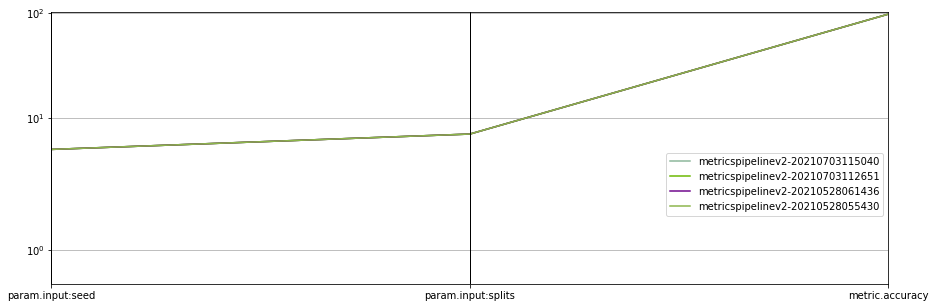

In [34]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="sklearn")

plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
    # color=['blue', 'green', 'pink', 'red'],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

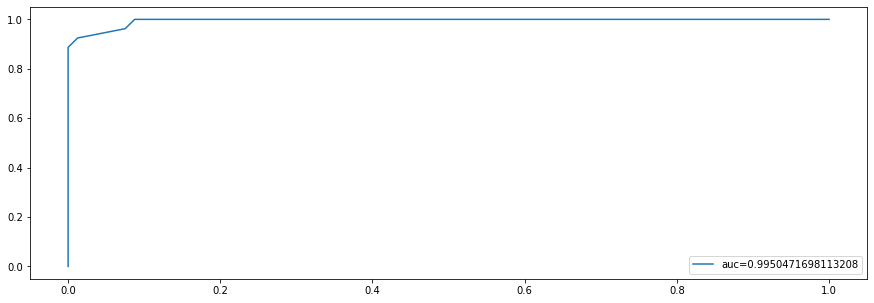

In [36]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="sklearn")
pipeline_df

df = pd.DataFrame(pipeline_df["metric.confidenceMetrics"][0])
auc = np.trapz(df["recall"], df["falsePositiveRate"])
plt.plot(df["falsePositiveRate"], df["recall"], label="auc=" + str(auc))
plt.legend(loc=4)
plt.show()